In [ ]:
#pip uninstall -y yfinance

In [ ]:
#pip install yfinance --upgrade --no-cache-dir

In [ ]:
#Améliorations du download:
#.  1. Télécharger et convertir la donnée https://stooq.com/db/h/
#.  2. Essayer yahooquery
#.  3. Essayer https://tiingo-python.readthedocs.io/en/latest/

In [ ]:
#pip install yfinance --upgrade

In [3]:
import yfinance as yf
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import random
import time
import requests
from typing import Dict, List
import logging
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Paramètres de téléchargement
INTERVALS = ['1h', '1d', '15m']
# Paramètres système
DATA_DIR = 'datasets'  # Répertoire des données
DATA_DIR_ENOUGH_DATA = 'datasets_enough_data'
TECH_DATA_DIR = 'datasets_technicals' #Répertoire pour sauvegarder les fichiers avec Indicateurs techniques
EDITED_DATA_DIR = 'datasets_edit'  # Répertoire pour sauvegarder les fichiers modifiés
# Paramètres de backtest
DATA_INTERVAL = '1d'  # Intervalle des données (exemple : '1m', '1h', '1d', etc.)
WINDOWS = [1800]
NUM_RANDOM_STARTS = 15
TRANSACTION_COST = 0.01

# Liste des tickers du CAC40 (ou autre indice)
TICKERS = [
    "EURUSD=X",
    # CAC40 tickers
    "AC.PA", "AI.PA", "AIR.PA", "MT.AS", "CS.PA", "BNP.PA", "EN.PA", "CAP.PA", "CA.PA", "ACA.PA", "BN.PA", "DSY.PA", "EDEN.PA",
    "ENGI.PA", "EL.PA", "ERF.PA", "RMS.PA", "KER.PA", "OR.PA", "LR.PA", "MC.PA", "ML.PA", "ORA.PA", "RI.PA", "PUB.PA", "RNO.PA",
    "SAF.PA", "SGO.PA", "SAN.PA", "SU.PA", "GLE.PA", "STLAP.PA", "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA", "URW.PA", "VIE.PA", "DG.PA", "VIV.PA",
    # S&P 500 tickers
    "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NVDA", "V", "JPM", "AAPL", 
    "JNJ", "WMT", "PG", "MA", "DIS", "HD", "PYPL", "INTC", "CSCO", "VZ", "UNH",
    "ADBE", "NFLX", "KO", "PFE", "XOM", "MRK", "NKE", "ABT", "PEP", "CRM",
    "TMO", "MDT", "LLY", "MS", "AVGO", "BA", "COST","STLA", "NESN.SW",
    # S&P 500
    "A", "AAL", "AAP", "ABBV", "ACN", "ADI",
    "ADM", "ADP", "ADSK", "AEE", "AEP", "AES", "AFL", "AIG", "AIV",
    "AIZ", "AJG", "AKAM", "ALB", "ALGN", "ALK", "ALL", "ALLE", "AMAT",
    "AMD", "AME", "AMGN", "AMP", "AMT", "ANET", "ANSS", "AON",
    "AOS", "APA", "APD", "APH", "APTV", "ARE", "ATO", "AVB",
    "AVY", "AWK", "AXP", "AZO", "BAC", "BAX", "BBY",
    "BDX", "BEN", "BIIB", "BK", "BKNG", "BKR", "BLK",
    "BMY", "BR", "BSX", "BWA", "BXP", "C", "CAG", "CAH", "CAT",
    "CB", "CBOE", "CBRE", "CCI", "CCL", "CDNS", "CE",
    "CF", "CFG", "CHD", "CHRW", "CHTR", "CI", "CINF", "CL", "CLX", "CMA",
    "CMCSA", "CME", "CMG", "CMI", "CMS", "CNC", "CNP", "COF", "COO",
    "COP", "COST", "CPB", "CPRT", "CRM", "CSCO", "CSX", "CTAS",
    "CVS", "CVX", "D", "DAL", "DD", "DE",
    "DFS", "DG", "DGX", "DHI", "DHR", "DIS", "DLR",
    "DLTR", "DOV", "DOW", "DRI", "DTE", "DUK", "DVA", "DVN", "DXC",
    "EA", "EBAY", "ECL", "ED", "EFX", "EIX", "EL", "EMN", "EMR", "EOG",
    "EQIX", "EQR", "ES", "ESS", "ETN", "ETR", "EVRG", "EW", "EXC",
    "EXPD", "EXPE", "EXR", "F", "FANG", "FAST", "FCX", "FDX",
    "FE", "FFIV", "FIS", "FITB", "FLR", "FLS", "FMC",
    "FOX", "FOXA", "FTNT", "FTV", "GD", "GE", "GIS", "GL", "GLW", "GM", "GOOG", "GPC", "GPN",
    "GS", "GWW", "HAL", "HAS", "HBAN", "HBI", "HCA", "HCP", "HD", "HES",
    "HIG", "HII", "HLT", "HOG", "HOLX", "HON", "HP", "HPE", "HPQ",
    "HRB", "HRL", "HSIC", "HST", "HSY", "HUM", "IBM", "ICE", "IDXX", "IEX",
    "IFF", "ILMN", "INCY", "INFO", "INTC", "INTU", "IP", "IPG", "IPGP",
    "IQV", "IR", "IRM", "ISRG", "IT", "ITW", "IVZ", "J", "JBHT", "JCI",
    "JKHY", "JNPR", "JWN", "K", "KEY", "KEYS",
    "KHC", "KIM", "KLAC", "KMB", "KMI", "KMX", "KO", "KR", "KSS",
    "L", "LB", "LDOS", "LEG", "LEN", "LH", "LHX", "LIN", "LKQ",
    "LMT", "LNC", "LNT", "LOW", "LRCX", "LUV", "LW", "LYB", "M",
    "MA", "MAA", "MAC", "MAR", "MAS", "MCD", "MCHP", "MCK", "MCO", "MDLZ",
    "MET", "MGM", "MHK", "MKC", "MKTX", "MLM", "MMC", "MMM", "MNST",
    "MO", "MOS", "MPC", "MRK", "MS", "MSCI", "MSFT", "MSI", "MTB",
    "MTD", "MU", "NAVI", "NCLH", "NDAQ", "NEE",
    "NEM", "NFLX", "NI", "NKE", "NOC", "NOV",
    "NRG", "NSC", "NTAP", "NTRS", "NUE", "NVDA", "NVR", "NWL", "NWS",
    "NWSA", "O", "ODFL", "OKE", "OMC", "ORCL", "ORLY", "OXY", "PAYC",
    "PAYX", "PCAR", "PEG", "PEP", "PFE", "PFG", "PG", "PGR",
    "PH", "PHM", "PLD", "PM", "PNC",
    "PNR", "PNW", "PPG", "PPL", "PRGO", "PRU", "PSA", "PSX", "PVH", "PWR",
    "PYPL", "QCOM", "QRVO", "RCL", "REG", "REGN", "RF", "RHI",
    "RJF", "RL", "RMD", "ROK", "ROL", "ROP", "ROST", "RSG", "RTX", "SBAC",
    "SBUX", "SCHW", "SEE", "SHW", "SJM", "SLB", "SLG", "SNA", "SNPS",
    "SO", "SPG", "SPGI", "SRE", "STE", "STT", "STX", "STZ", "SWK", "SWKS",
    "SYY", "T", "TAP", "TDG", "TEL", "TER", "TFC", "TFX", "TGT", 
    "TJX", "TMUS", "TMO", "TPR", "TRMB", "TROW", "TRV", "TSCO", "TSLA",
    "TSN", "TT", "TTWO", "TXN", "TXT", "TYL", "UA", "UAA", "UAL",
    "UDR", "UHS", "ULTA", "UNH", "UNM", "UNP", "UPS", "URI", "USB", "V",
    "VFC", "VLO", "VMC", "VNO", "VRSK", "VRSN", "VRTX",
    "VTR", "VZ", "WAB", "WAT", "WBA", "WDC", "WEC", "WELL", "WFC",
    "WHR", "WM", "WMB", "WMT", "WRB", "WU", "WY", "WYNN",
    "XEL", "XOM", "XRAY", "XRX", "XYL", "YUM", "ZBH", "ZBRA", "ZION", "ZTS",
    # NASDAQ tickers
    "QCOM", "MU", "INTU", "AMD", "AMAT", "EBAY", "SBUX",
    # DAX tickers
    "ADS.DE", "ALV.DE", "BAS.DE", "BMW.DE", "CON.DE", "DB1.DE", "DTE.DE", "LHA.DE",
    "LIN.DE", "MUV2.DE", "RWE.DE", "SAP.DE", "SIE.DE", "VOW3.DE", "ZAL.DE",
    # FTSE tickers
    "AAL.L", "ABF.L", "ADM.L", "AHT.L", "AV.L", "BA.L", "BARC.L", "BATS.L", "BP.L",
    "BTI", "CNA.L", "DGE.L", "GSK.L", "HSBA.L", "IMB.L", "ITV.L", "LGEN.L", "LLOY.L",
    "RDSA.VI",
    # EURO STOXX 50 tickers
    "INGA.AS", "PUM.DE", "NOKIA.HE",
    # Dow Jones tickers
    "IBM", "MCD", "GS",
    # Hong Kong Stock Exchange tickers
    "2388.HK", "1398.HK",
    # Shanghai Stock Exchange tickers
    "600519.SS", "601988.SS", "601288.SS", "601318.SS", "000651.SZ", "002475.SZ",
    # Australian Securities Exchange tickers
    "BHP.AX", "CBA.AX", "TLS.AX", "WBC.AX", "CSL.AX", "NAB.AX", "ANZ.AX", "RIO.AX",
    "QBE.AX", "WOW.AX", "S32.AX", "FMG.AX", "MQG.AX",
    # Canadian Securities Exchange tickers
    "TD.TO", "RY.TO", "BNS.TO", "ENB.TO", "SU.TO", "CNQ.TO", "BMO.TO", "SHOP.TO",
    "SLF.TO", "MFC.TO", "PPL.TO", "TRP.TO",
    # Other notable global tickers
    "TSM", "BABA", "SAP", "ASML", "VOW.DE", "LVMUY", "KHC",
]



# Ticker du taux sans risque (bons du Trésor à 13 semaines)
RISK_FREE_TICKER = '^IRX'
riskfreerate = yf.download(RISK_FREE_TICKER, period='max', interval='1d')
# Vérifier si le DataFrame n'est pas vide
if riskfreerate.empty:
    print("Aucune donnée récupérée pour le taux sans risque.")
else:
    # Sélectionner uniquement les colonnes 'Date' et 'Close' et réinitialiser l'index
    riskfreerate = riskfreerate[['Close']].reset_index()
    # Renommer la colonne 'Date' si nécessaire et supprimer la ligne de titre incorrecte
    riskfreerate.columns = ['Date', 'Close']  # Si le nom de la colonne Date ne correspond pas à votre besoin
    # Sauvegarder dans un fichier CSV sans l'index
    riskfreerate.to_csv('RISK_FREE_TICKER.csv', index=False)
    print(f'Données sauvegardées dans RISK_FREE_TICKER.csv')
riskfreerate

[*********************100%***********************]  1 of 1 completed

Données sauvegardées dans RISK_FREE_TICKER.csv


Date  Close
0     1960-01-04  4.520
1     1960-01-05  4.550
2     1960-01-06  4.680
3     1960-01-07  4.630
4     1960-01-08  4.590
...          ...    ...
16272 2025-01-15  4.205
16273 2025-01-16  4.195
16274 2025-01-17  4.193
16275 2025-01-21  4.197
16276 2025-01-22  4.215

[16277 rows x 2 columns]

In [4]:
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import os
import random
import time
import requests
from typing import Dict, List

# Constants
INTERVAL_DELAY = 5.3  # Delay between intervals in seconds
MIN_NB_LINES = 200  # Minimum number of lines required

USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0",
    "Mozilla/5.0 (Linux; Android 10; SM-G970F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Mobile Safari/537.36"
]

class SmartRateLimiter:
    def __init__(self, min_delay: float = 0.5, max_delay: float = 4.0, max_retry_delay: float = 15.0):
        self.min_delay = min_delay
        self.max_delay = max_delay
        self.max_retry_delay = max_retry_delay
        self.last_request_time = 0
        self.consecutive_failures = 0

    def wait(self):
        current_time = time.time()
        elapsed = current_time - self.last_request_time
        delay = random.uniform(self.min_delay, self.max_delay)
        if elapsed < delay:
            time.sleep(delay - elapsed)
        self.last_request_time = time.time()

    def backoff(self):
        self.consecutive_failures += 1
        delay = min(self.max_retry_delay, (2 ** self.consecutive_failures) + random.uniform(0, 1))
        time.sleep(delay)

    def success(self):
        self.consecutive_failures = 0

class StockDownloader:
    def __init__(self, batch_size: int = 50, cache_dir: str = 'yfinance_cache'):
        self.batch_size = batch_size
        self.rate_limiter = SmartRateLimiter()

    def process_dataframe(self, df):
        """Process a DataFrame to standardize format"""
        if df is not None and len(df) > 0:
            df.index.name = 'Date'  # Rename Datetime to Date
            df = df.dropna(how='all')  # Drop empty rows
            return df
        return None

    def download_batch(self, tickers: List[str], interval: str, pbar: tqdm, retry_count: int = 0) -> Dict:
        if retry_count >= 3:
            pbar.update(len(tickers))
            return {}, tickers

        try:
            self.rate_limiter.wait()

            session = requests.Session()
            session.headers.update({'User-Agent': random.choice(USER_AGENTS)})

            data = yf.download(
                tickers=" ".join(tickers),
                interval=interval,
                group_by='ticker',
                auto_adjust=True,
                prepost=False,
                timeout=20,
                session=session,
                progress=False
            )

            results = {}
            failed_tickers = []

            for ticker in tickers:
                try:
                    ticker_data = data[ticker].copy() if ticker in data else None
                    if ticker_data is not None and len(ticker_data) >= MIN_NB_LINES:
                        results[ticker] = self.process_dataframe(ticker_data)
                    else:
                        failed_tickers.append(ticker)
                except Exception:
                    failed_tickers.append(ticker)
                pbar.update(1)

            self.rate_limiter.success()
            return results, failed_tickers

        except Exception:
            self.rate_limiter.backoff()
            return self.download_batch(tickers, interval, pbar, retry_count + 1)

    def save_interval_results(self, results: Dict, base_dir: str, interval: str, batch_size: int = 100):
        interval_dir = f"{base_dir}/{interval}"
        os.makedirs(interval_dir, exist_ok=True)

        tickers_to_process = [(ticker, data) for ticker, data in results.items() if data is not None and not data.empty]

        for i in range(0, len(tickers_to_process), batch_size):
            batch = tickers_to_process[i:i + batch_size]

            with tqdm(total=len(batch), desc=f"Saving {interval} files (batch {i // batch_size + 1}/{len(tickers_to_process) // batch_size + 1})") as pbar:
                for ticker, new_data in batch:
                    try:
                        if len(new_data) < MIN_NB_LINES:
                            print(f"{ticker}: insufficient data ({len(new_data)} rows). Removing...")

                            for intv in INTERVALS:
                                ticker_file = os.path.join(base_dir, intv, f"{ticker}.csv")
                                if os.path.exists(ticker_file):
                                    os.remove(ticker_file)
                                    print(f"Deleted file: {ticker_file}")

                            if ticker in TICKERS:
                                TICKERS.remove(ticker)
                                print(f"Removed ticker {ticker} from list.")
                            continue

                        file_path = f"{interval_dir}/{ticker}.csv"

                        if os.path.exists(file_path):
                            existing_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
                            merged_data = pd.concat([existing_data, new_data])
                            merged_data = merged_data[~merged_data.index.duplicated(keep='last')].sort_index()
                        else:
                            merged_data = new_data

                        merged_data.to_csv(file_path)
                    except Exception as e:
                        print(f"Error processing {ticker}: {e}")
                    finally:
                        pbar.update(1)

            del batch
            import gc
            gc.collect()

    def download_all(self, tickers: List[str], intervals: List[str]) -> Dict:
        all_results = {interval: {} for interval in intervals}
        all_failed = {interval: [] for interval in intervals}

        for interval in intervals:
            batches = [tickers[i:i + self.batch_size] for i in range(0, len(tickers), self.batch_size)]
            total_tickers = len(tickers)

            with tqdm(total=total_tickers, desc=f"Downloading {interval}") as pbar:
                for batch in batches:
                    results, failed = self.download_batch(batch, interval, pbar)
                    if results:
                        all_results[interval].update(results)
                    all_failed[interval].extend(failed)

            self.save_interval_results(all_results[interval], DATA_DIR, interval)

            if interval != intervals[-1]:
                time.sleep(INTERVAL_DELAY)

        return all_results, all_failed

if __name__ == "__main__":
    downloader = StockDownloader(batch_size=50)
    results, failed = downloader.download_all(tickers=TICKERS, intervals=INTERVALS)

    print("\nDownload Summary:")
    for interval in INTERVALS:
        success_count = len(results[interval])
        fail_count = len(failed[interval])
        print(f"{interval}: {success_count} succeeded, {fail_count} failed")


12 Failed downloads:
['CRM', 'MA', 'AEP', 'ADM', 'LLY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2023-01-24 06:16:12-05:00 -> 2025-01-23 06:16:12-05:00) (Yahoo error = "1h data not available for startTime=1674558972 and endTime=1737630972. The requested range must be within the last 730 days.")')
['COST', 'MRK', 'AIV', 'STLA', 'ALB']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2023-01-24 06:16:13-05:00 -> 2025-01-23 06:16:13-05:00) (Yahoo error = "1h data not available for startTime=1674558973 and endTime=1737630973. The requested range must be within the last 730 days.")')
['WMT', 'ABBV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2023-01-24 06:16:14-05:00 -> 2025-01-23 06:16:14-05:00) (Yahoo error = "1h data not available for startTime=1674558974 and endTime=1737630974. The requested range must be within the last 730 days.")')
5 Failed downloads:
['AMT', 'BLK', 'APD']: YFPricesMi

INFO: insufficient data (105 rows). Removing...
Removed ticker INFO from list.


Saving 1h files (batch 5/6): 100%|██████████| 100/100 [00:03<00:00, 28.08it/s]
1 Failed download:
['ZAL.DE']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))
Saving 1d files (batch 4/6):   4%|▍         | 4/100 [00:00<00:02, 33.70it/s]

LB: insufficient data (142 rows). Removing...
Deleted file: datasets/1h/LB.csv
Removed ticker LB from list.


Saving 1d files (batch 6/6): 100%|██████████| 65/65 [00:02<00:00, 27.82it/s]
10 Failed downloads:
['ALB', 'MRK', 'STLA', 'COST', 'AIV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (15m 2024-11-24 06:18:25-05:00 -> 2025-01-23 06:18:25-05:00) (Yahoo error = "15m data not available for startTime=1732447105 and endTime=1737631105. The requested range must be within the last 60 days.")')
['AEE', 'KO', 'HD', 'AKAM', 'DIS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (15m 2024-11-24 06:18:26-05:00 -> 2025-01-23 06:18:26-05:00) (Yahoo error = "15m data not available for startTime=1732447106 and endTime=1737631106. The requested range must be within the last 60 days.")')
1 Failed download:
['CE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (15m 2024-11-24 06:18:27-05:00 -> 2025-01-23 06:18:27-05:00) (Yahoo error = "15m data not available for startTime=1732447107 and endTime=1737631107. The requested range 


Download Summary:
1h: 567 succeeded, 0 failed
1d: 566 succeeded, 0 failed
15m: 340 succeeded, 251 failed



Traitement des fichiers dans l'intervalle : 1h
Seuil pour 1h: 3497.50
Top-10 fichiers pour l'intervalle 1h :
RDSA.VI.csv: 506 lignes
600519.SS.csv: 2629 lignes
601988.SS.csv: 2744 lignes
601288.SS.csv: 2766 lignes
601318.SS.csv: 2793 lignes
000651.SZ.csv: 2910 lignes
002475.SZ.csv: 2910 lignes
2388.HK.csv: 3405 lignes
1398.HK.csv: 3406 lignes
BIIB.csv: 3486 lignes
Nombre de fichiers à conserver : 453
Nombre de fichiers à supprimer : 112


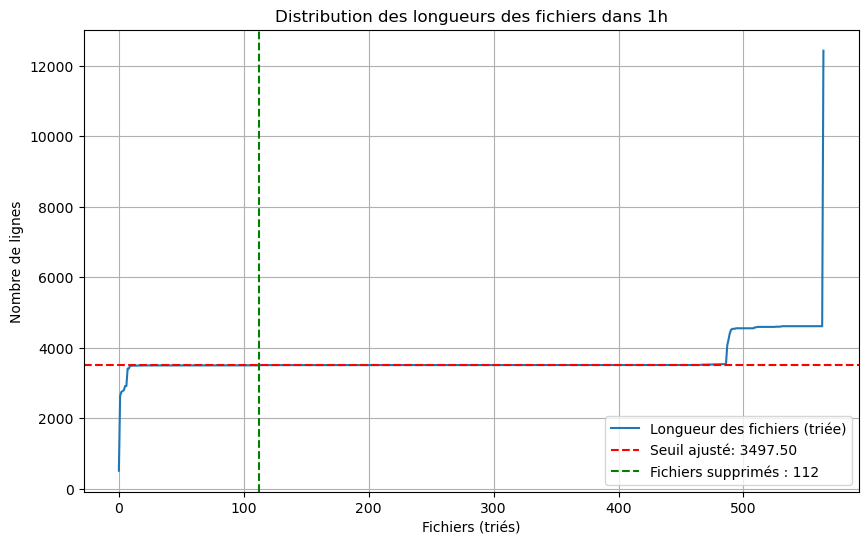


Traitement des fichiers dans l'intervalle : 1d
Seuil pour 1d: 1908.25
Top-10 fichiers pour l'intervalle 1d :
URW.PA.csv: 453 lignes
HCP.csv: 780 lignes
DOW.csv: 1468 lignes
FOX.csv: 1473 lignes
FOXA.csv: 1474 lignes
RDSA.VI.csv: 1838 lignes
IR.csv: 1933 lignes
LW.csv: 2058 lignes
FTV.csv: 2149 lignes
UA.csv: 2220 lignes
Nombre de fichiers à conserver : 559
Nombre de fichiers à supprimer : 6


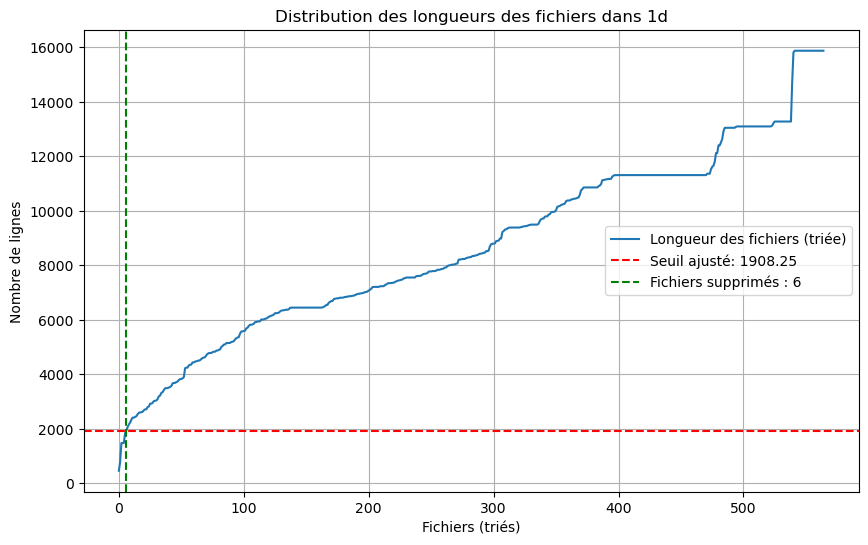


Traitement des fichiers dans l'intervalle : 15m
Seuil pour 15m: 981.00
Top-10 fichiers pour l'intervalle 15m :
600519.SS.csv: 678 lignes
601318.SS.csv: 686 lignes
601988.SS.csv: 686 lignes
601288.SS.csv: 687 lignes
1398.HK.csv: 869 lignes
2388.HK.csv: 870 lignes
000651.SZ.csv: 902 lignes
002475.SZ.csv: 902 lignes
MTD.csv: 907 lignes
BKNG.csv: 918 lignes
Nombre de fichiers à conserver : 458
Nombre de fichiers à supprimer : 103


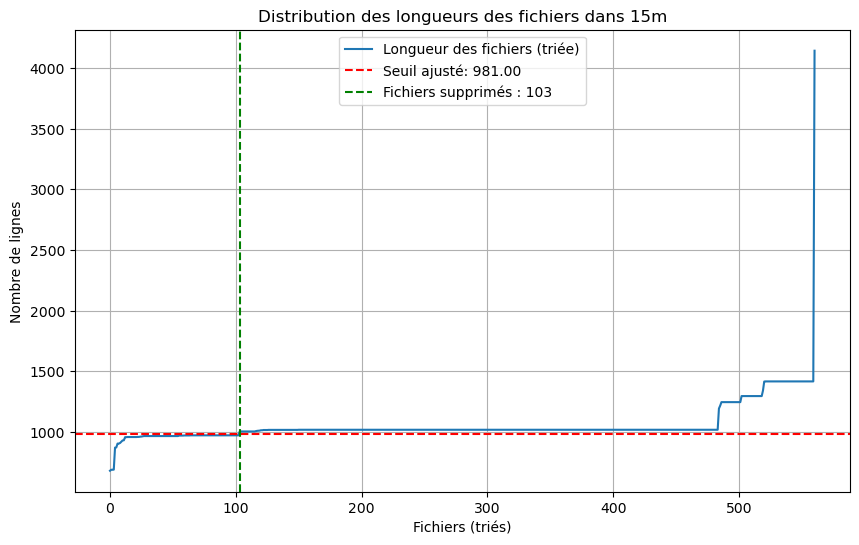

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Dictionnaire global pour stocker les seuils calculés
seuils = {}

def analyze_and_plot_csv_files_by_iqr(data_dir, intervals, iqr_factor=1.5, top_n=10):
    """
    Analyse les fichiers CSV et calcule les seuils IQR par intervalle. Affiche le top-10 des fichiers les plus courts
    et trace les graphiques.

    Args:
        data_dir (str): Dossier contenant les sous-dossiers d'intervalles.
        intervals (list): Liste des sous-dossiers à traiter.
        iqr_factor (float): Facteur pour le calcul du seuil basé sur l'IQR.
        top_n (int): Nombre de fichiers les plus courts à afficher.
    """
    global seuils  # Accès à la variable globale seuils
    
    for interval in intervals:
        folder_path = os.path.join(data_dir, interval)
        if not os.path.exists(folder_path):
            print(f"Le dossier {folder_path} n'existe pas.")
            continue

        print(f"\nTraitement des fichiers dans l'intervalle : {interval}")
        file_stats = []

        # Lecture des fichiers et comptage des lignes
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path) and filename.endswith('.csv'):
                try:
                    with open(file_path, 'r') as f:
                        num_lines = sum(1 for _ in f) - 1  # Ignorer l'en-tête
                    file_stats.append((num_lines, filename))
                except Exception as e:
                    print(f"Erreur de lecture du fichier {file_path}: {e}")

        if not file_stats:
            print(f"Aucun fichier valide dans {interval}.")
            continue

        # Calcul des quartiles et IQR
        lengths = np.array([num_lines for num_lines, _ in file_stats])
        Q1 = np.percentile(lengths, 20)
        Q3 = np.percentile(lengths, 75)
        IQR = Q3 - Q1

        # Calcul du seuil basé sur l'IQR
        threshold = Q1 - iqr_factor * IQR
        adjusted_iqr_factor = iqr_factor
        while threshold <= 0 and adjusted_iqr_factor > 0.1:  # Réduire le facteur jusqu'à obtenir un seuil positif
            adjusted_iqr_factor /= 2
            threshold = Q1 - adjusted_iqr_factor * IQR

        if threshold <= 0:  # En dernier recours, utiliser une fraction de Q1
            threshold = Q1 * 0.5
            print(f"Seuil ajusté manuellement à une fraction de Q1 : {threshold:.2f}")

        # Stockage du seuil dans la variable globale
        seuils[interval] = threshold
        print(f"Seuil pour {interval}: {threshold:.2f}")

        # Affichage du top-N des fichiers les plus courts
        file_stats.sort()
        print(f"Top-{top_n} fichiers pour l'intervalle {interval} :")
        for num_lines, filename in file_stats[:top_n]:
            print(f"{filename}: {num_lines} lignes")

        # Calcul du nombre de fichiers à conserver et à supprimer
        files_to_keep = [num_lines for num_lines, _ in file_stats if num_lines >= threshold]
        files_to_delete = [num_lines for num_lines, _ in file_stats if num_lines < threshold]

        print(f"Nombre de fichiers à conserver : {len(files_to_keep)}")
        print(f"Nombre de fichiers à supprimer : {len(files_to_delete)}")

        # Plot des longueurs de fichiers avec le seuil
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(lengths)), np.sort(lengths), label='Longueur des fichiers (triée)')
        plt.axhline(y=threshold, color='red', linestyle='--', label=f'Seuil ajusté: {threshold:.2f}')
        
        # Ajouter une ligne verticale pour séparer les fichiers conservés et supprimés
        plt.axvline(x=len(files_to_delete), color='green', linestyle='--', label=f'Fichiers supprimés : {len(files_to_delete)}')

        plt.title(f'Distribution des longueurs des fichiers dans {interval}')
        plt.xlabel('Fichiers (triés)')
        plt.ylabel('Nombre de lignes')
        plt.legend()
        plt.grid(True)
        plt.show()

# Exemple d'exécution
analyze_and_plot_csv_files_by_iqr(DATA_DIR, INTERVALS, iqr_factor=1.5, top_n=10)


In [5]:
import os
import shutil

def copy_valid_csv_files(data_dir, intervals, seuils, data_dir_enough_data):
    """
    Copie les fichiers CSV dont le nombre de lignes est supérieur au seuil respectif dans un dossier cible.

    Args:
        data_dir (str): Dossier contenant les sous-dossiers d'intervalles.
        intervals (list): Liste des sous-dossiers à traiter.
        seuils (dict): Dictionnaire contenant les seuils calculés pour chaque intervalle.
        data_dir_enough_data (str): Dossier où les fichiers valides seront copiés.
    """
    for interval in intervals:
        folder_path = os.path.join(data_dir, interval)
        if not os.path.exists(folder_path):
            print(f"Le dossier {folder_path} n'existe pas.")
            continue

        # Créer le dossier cible si nécessaire
        target_folder_path = os.path.join(data_dir_enough_data, interval)
        os.makedirs(target_folder_path, exist_ok=True)

        print(f"\nTraitement des fichiers dans l'intervalle : {interval}")

        if interval not in seuils:
            print(f"Aucun seuil trouvé pour l'intervalle {interval}.")
            continue

        threshold = seuils[interval]
        print(f"Seuil pour {interval}: {threshold:.2f}")

        # Lecture des fichiers et comptage des lignes
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path) and filename.endswith('.csv'):
                try:
                    with open(file_path, 'r') as f:
                        num_lines = sum(1 for _ in f) - 1  # Ignorer l'en-tête
                    # Si le fichier a plus de lignes que le seuil, le copier
                    if num_lines >= threshold:
                        target_file_path = os.path.join(target_folder_path, filename)
                        shutil.copy(file_path, target_file_path)  # Copier le fichier
                        #print(f"Fichier copié : {file_path} vers {target_file_path} ({num_lines} lignes)")
                except Exception as e:
                    print(f"Erreur de lecture du fichier {file_path}: {e}")

# Exemple d'exécution

DATA_DIR_ENOUGH_DATA = 'datasets_enough_data'  # Dossier cible pour les données suffisamment longues
copy_valid_csv_files(DATA_DIR, INTERVALS, seuils, DATA_DIR_ENOUGH_DATA)



Traitement des fichiers dans l'intervalle : 1h
Seuil pour 1h: 3497.50

Traitement des fichiers dans l'intervalle : 1d
Seuil pour 1d: 1908.25

Traitement des fichiers dans l'intervalle : 15m
Seuil pour 15m: 981.00


In [6]:
import os
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

DATA_DIR_ENOUGH_DATA = 'datasets_enough_data'
TECH_DATA_DIR = 'datasets_technicals'
os.makedirs(DATA_DIR_ENOUGH_DATA, exist_ok=True)
os.makedirs(TECH_DATA_DIR, exist_ok=True)

# Liste pour stocker les erreurs
error_list = []


# Fonction pour charger les données en tenant compte du nom de la colonne de date
def load_data(filename):
    """
    Charge les données CSV, supprime les lignes avec des valeurs manquantes avant la première ligne 'Close' renseignée.
    """
    try:
        if os.path.getsize(filename) == 0:
            print(f"Le fichier {filename} est vide.")
            return None

        df = pd.read_csv(filename, parse_dates=['Date'])
        #print(f"Chargement de {filename} réussi. Taille du DataFrame : {df.shape}")

        # Suppression des lignes avant la première ligne valide de 'Close'
        if 'Close' in df.columns:
            first_valid_index = df['Close'].first_valid_index()
            if first_valid_index is not None:
                df = df.loc[first_valid_index:].reset_index(drop=True)
            else:
                print(f"Aucune valeur valide trouvée dans la colonne 'Close' de {filename}.")
                return None

        # S'assurer que 'Date' est l'index
        if 'Date' in df.columns:
            df.set_index('Date', inplace=True)
        return df
    except Exception as e:
        error_list.append((filename, f"Erreur lors du chargement: {str(e)}"))
        print(f"Erreur lors du chargement de {filename}: {e}")
        return None

# Optimisation des calculs d'indicateurs
def compute_indicators(df):
    if df is None:
        return None

    # RSI14:
    def compute_rsi(series, period=14):
        #Calcule le RSI en s'assurant que la série n'a pas de valeurs manquantes.
        # Supprime les NaN pour éviter des erreurs dans le calcul
        series = series.dropna()
        delta = series.diff()  # Différence entre les prix consécutifs
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()  # Gains
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()  # Pertes
        rs = gain / loss  # Rapport des gains et des pertes
        rsi = 100 - (100 / (1 + rs))  # Calcul du RSI
        # Réindexer pour conserver la structure du DataFrame d'origine
        rsi = rsi.reindex(series.index)
        return rsi
    # Calcul du RSI et ajout au DataFrame
    df['RSI14'] = compute_rsi(df['Close'])


    # Stochastiques:
    def compute_stochastic(high, low, close, k_period=14, d_period=3):
        # Supprimez les NaN pour éviter des erreurs dans le calcul
        high, low, close = high.dropna(), low.dropna(), close.dropna()
        lowest_low = low.rolling(window=k_period).min()
        highest_high = high.rolling(window=k_period).max()
        k = 100 * (close - lowest_low) / (highest_high - lowest_low)
        d = k.rolling(window=d_period).mean()
        # Réindexer pour conserver la structure du DataFrame d'origine
        k, d = k.reindex(close.index), d.reindex(close.index)
        return k, d
    df['Stochastic_K14'], df['Stochastic_D14'] = compute_stochastic(
        df['High'], df['Low'], df['Close']
    )

    # Mean Reversion Channel:
    rolling_mean = df['Close'].dropna().rolling(window=20).mean().reindex(df.index)
    rolling_std = df['Close'].dropna().rolling(window=20).std().reindex(df.index)
    df['MRC_Upper'] = rolling_mean + 2 * rolling_std
    df['MRC_Lower'] = rolling_mean - 2 * rolling_std

    # SMA:
    for period in [10, 20, 50, 100, 200]:
        df[f'SMA{period}'] = df['Close'].dropna().rolling(window=period).mean().reindex(df.index)
        
    # EMA:
    def compute_ema(series, span):
        series = series.dropna()
        ema = series.ewm(span=span, adjust=False).mean()
        return ema.reindex(series.index)
    for span in [10, 20, 50]:
        df[f'EMA{span}'] = compute_ema(df['Close'], span)


    #Momentum(%):
    def compute_momentum(df, periods):
        for period in periods:
            df['Close'] = df['Close'].ffill()  # Remplir les NaN en avant
            df[f'Momentum{period}'] = df['Close'].pct_change(periods=period) * 100
    compute_momentum(df, [20, 50, 100, 360])

            
    return df

# Fonction pour traiter un ticker et un intervalle
def process_data_for_ticker_and_interval(ticker, interval):
    source_path = os.path.join(DATA_DIR_ENOUGH_DATA, interval, f"{ticker}.csv")
    if not os.path.exists(source_path):
        error_list.append((ticker, interval, "Fichier manquant"))
        #print(f"Fichier manquant pour {ticker} : {source_path}")
        return

    df = load_data(source_path)
    if df is None:
        error_list.append((ticker, interval, "Erreur lors du chargement"))
        return

    # Calcul des indicateurs
    df_with_indicators = compute_indicators(df)

    # Sauvegarder les données modifiées dans le sous-dossier TECH_DATA_DIR
    if df_with_indicators is not None:
        destination_path = os.path.join(TECH_DATA_DIR, interval, f"{ticker}.csv")
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        df_with_indicators.to_csv(destination_path)
    else:
        print(f"Aucun indicateur calculé pour {ticker}, DataFrame vide.")


# Traitement parallèle
def process_all_data():
    for interval in INTERVALS:
        print(f"Traitement des données pour l'intervalle : {interval}")

        Parallel(n_jobs=-1)(
            delayed(process_data_for_ticker_and_interval)(ticker, interval)
            for ticker in tqdm(TICKERS, desc=f"Traitement pour {interval}")
        )

    if error_list:
        print("\nErreurs détectées :")
        for ticker, interval, reason in error_list:
            print(f"Ticker: {ticker}, Intervalle: {interval}, Raison: {reason}")
    else:
        print("\nAucune erreur détectée.")


# Lancer le traitement
process_all_data()


Traitement des données pour l'intervalle : 1h


Traitement pour 1h: 100%|██████████| 601/601 [00:09<00:00, 60.37it/s]


Traitement des données pour l'intervalle : 1d


Traitement pour 1d: 100%|██████████| 601/601 [00:13<00:00, 45.31it/s]


Traitement des données pour l'intervalle : 15m


Traitement pour 15m: 100%|██████████| 601/601 [00:01<00:00, 343.95it/s]



Aucune erreur détectée.


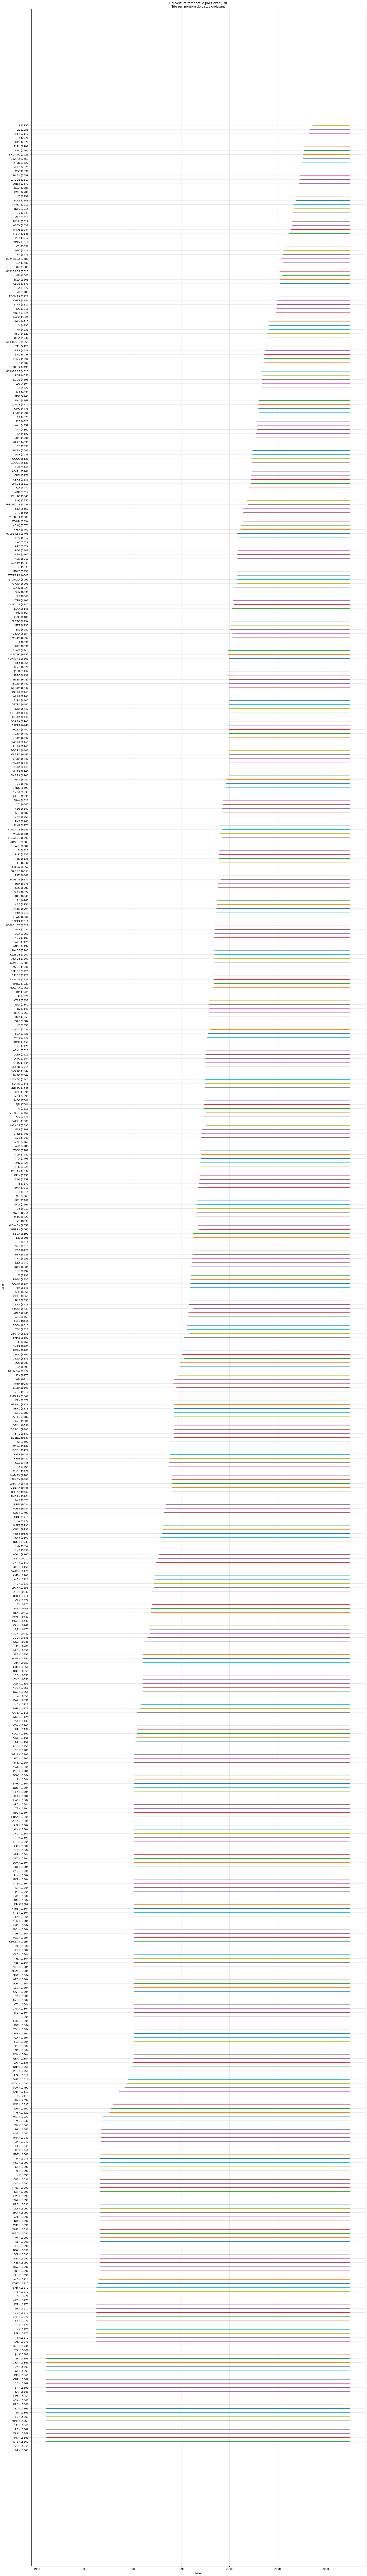

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import os
DATA_INTERVAL='1d'
def plot_simple_coverage(data_dir, interval):
    """
    Crée un plot simple montrant toutes les dates de tous les fichiers,
    triés par nombre de dates croissant.
    """
    folder_path = os.path.join(data_dir, interval)
    
    # Collecter les informations de dates pour chaque ticker
    ticker_info = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            ticker = filename[:-4]
            df = pd.read_csv(os.path.join(folder_path, filename))
            dates = pd.to_datetime(df['Date'])
            ticker_info.append({
                'ticker': ticker,
                'start': dates.min(),
                'end': dates.max(),
                'count': len(dates)
            })
    
    # Trier par nombre de dates
    ticker_info = sorted(ticker_info, key=lambda x: -x['count'])
    
    plt.figure(figsize=(20, max(10, len(ticker_info)/4)))
    
    # Tracer les lignes dans l'ordre trié
    for i, info in enumerate(ticker_info):
        plt.plot([info['start'], info['end']], [i, i], '-', 
                linewidth=2, label=info['ticker'])
    
    plt.grid(True, alpha=0.3)
    plt.title(f'Couverture temporelle par ticker ({interval})\nTrié par nombre de dates croissant')
    plt.xlabel('Date')
    plt.ylabel('Ticker')
    plt.yticks(range(len(ticker_info)), 
               [f"{info['ticker']} ({info['count']})" for info in ticker_info])
    plt.tight_layout()
    
    return plt.gcf()

# Créer la visualisation
fig = plot_simple_coverage(TECH_DATA_DIR, DATA_INTERVAL)


Suppression du répertoire existant datasets_backtest...
Création du répertoire datasets_backtest...


Veuillez entrer une date au format yyyy-mm-dd (laisser vide pour une plage commune auto.) :  2021-02-02


Traitement des fichiers pour 1d: 100%|██████████| 564/564 [00:35<00:00, 16.09fichier/s]


Max window size pour 1d: 2807 jours

Execution time: 59.56 seconds


Processing tasks: 100%|█████████████████████████████████████████████| 50/50 [02:01<00:00,  2.42s/it]



Execution time: 157.17 seconds


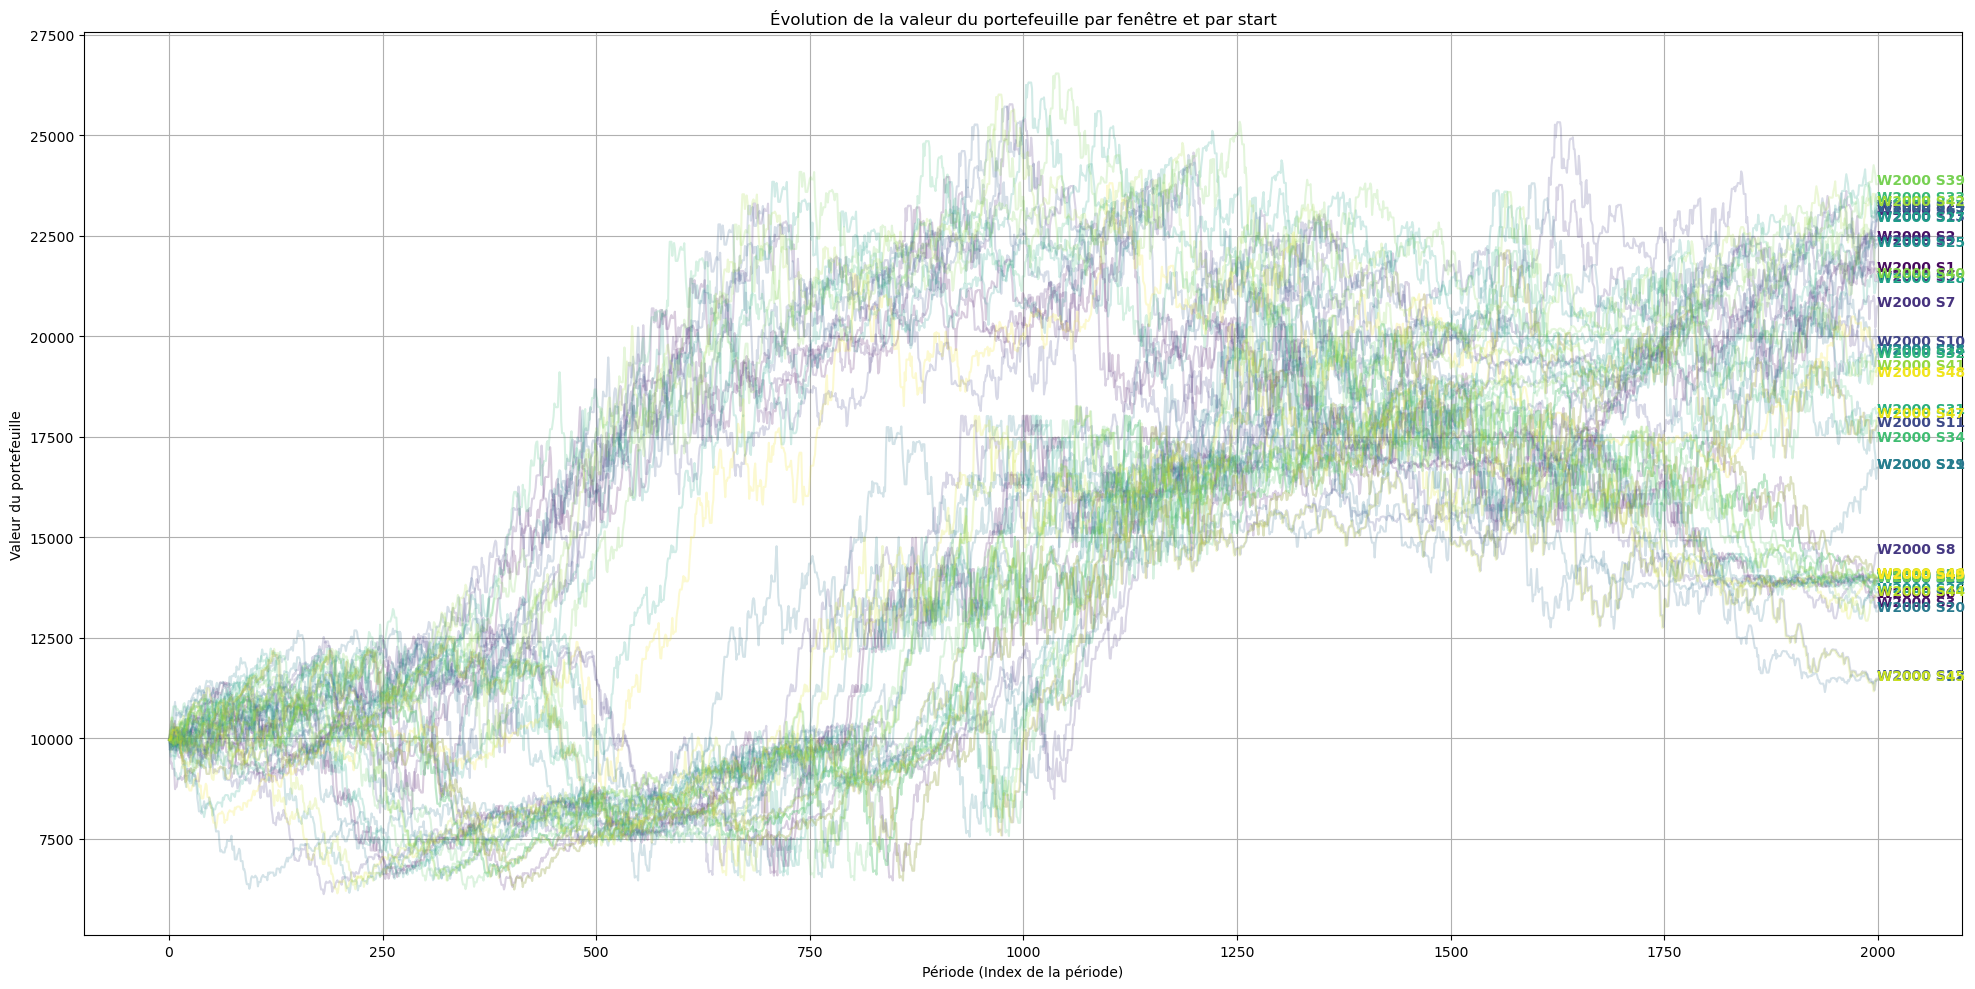

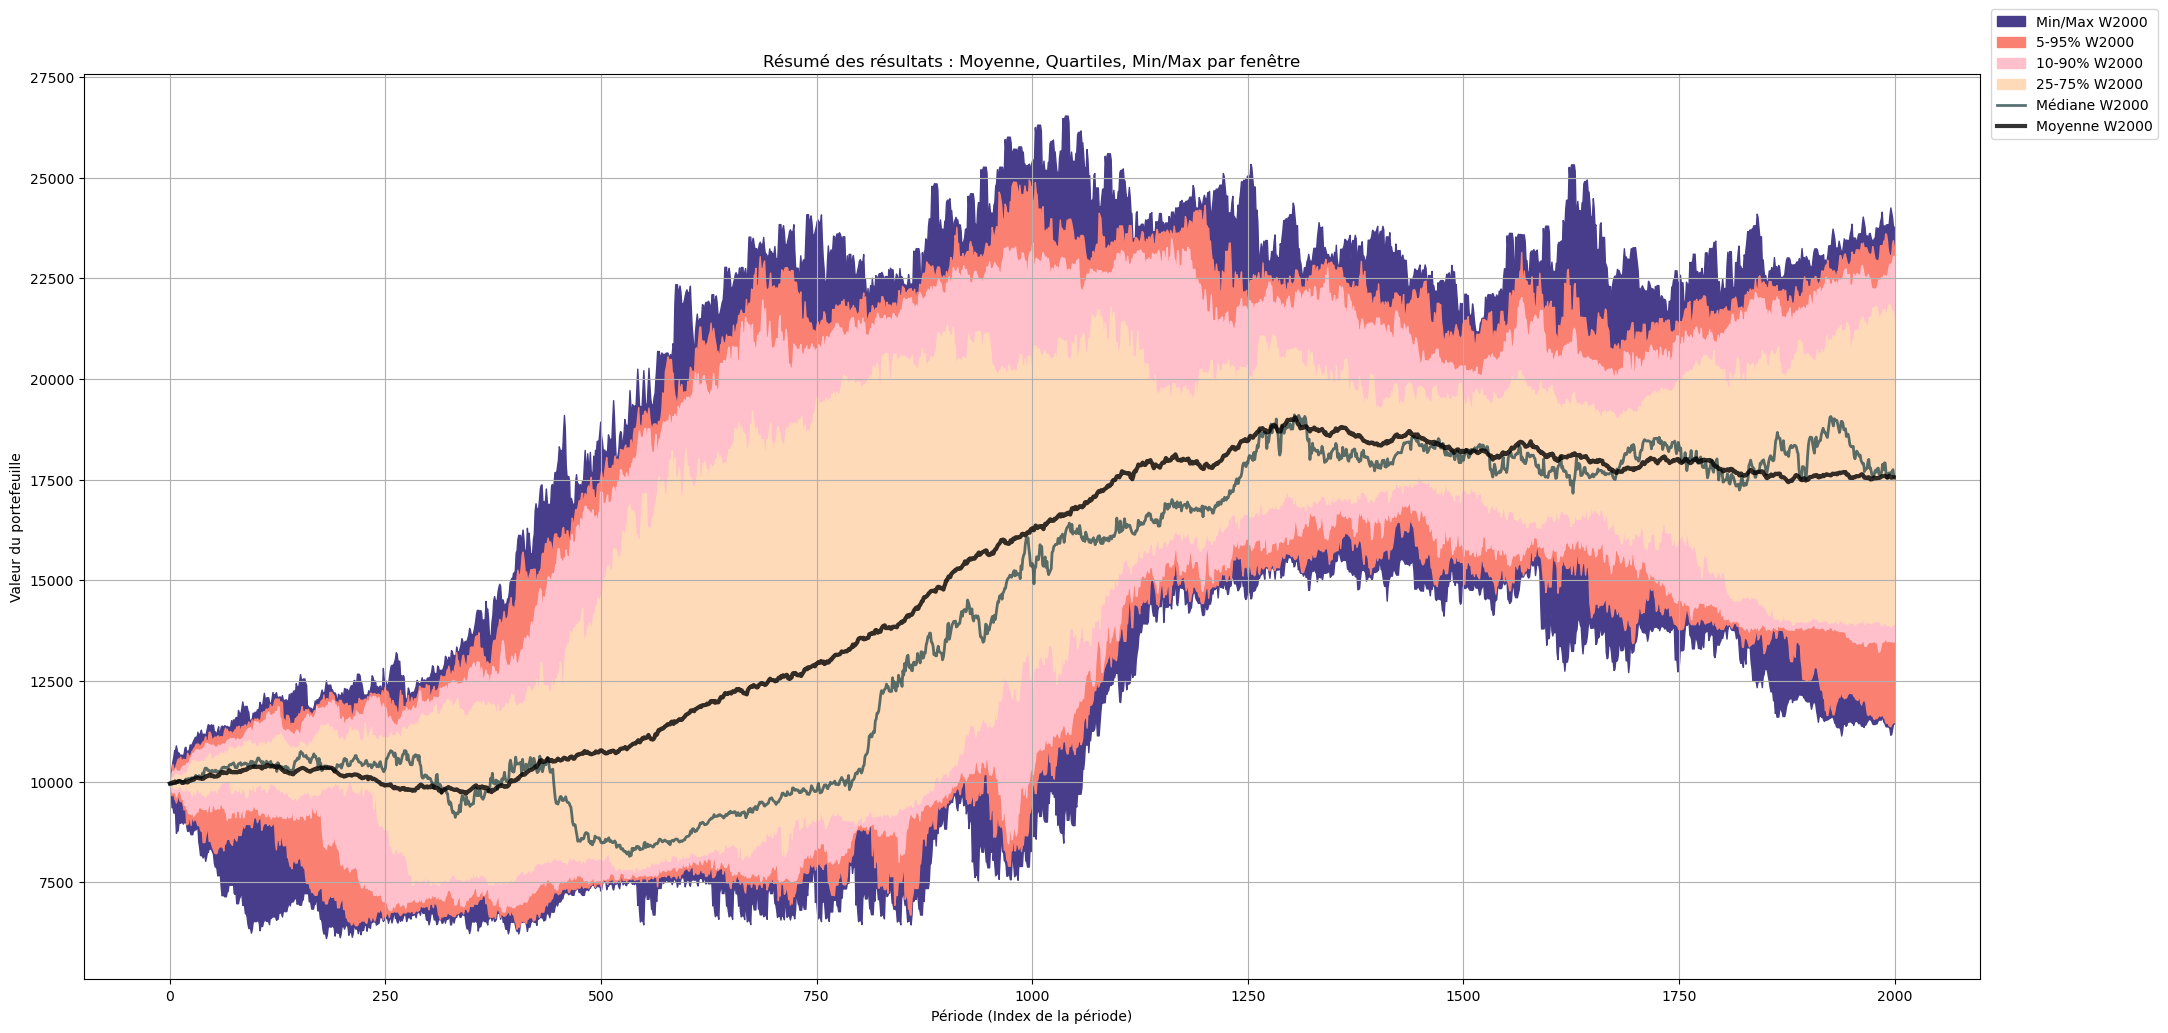

portfolio_value  window  ticker  start  period  \
1999       13990.0625    2000     WHR     49    1999   
1999       13990.0625    2000      WM     49    1999   
1999       13990.0625    2000     WMB     49    1999   
1999       13990.0625    2000     WMT     49    1999   
1999       13990.0625    2000  WOW.AX     49    1999   
1999       13990.0625    2000     WRB     49    1999   
1999       13990.0625    2000      WU     49    1999   
1999       13990.0625    2000      WY     49    1999   
1999       13990.0625    2000    WYNN     49    1999   
1999       13990.0625    2000     XEL     49    1999   
1999       13990.0625    2000     XOM     49    1999   
1999       13990.0625    2000    XRAY     49    1999   
1999       13990.0625    2000     XRX     49    1999   
1999       13990.0625    2000     XYL     49    1999   
1999       13990.0625    2000     YUM     49    1999   
1999       13990.0625    2000  ZAL.DE     49    1999   
1999       13990.0625    2000     ZBH     49    1999   
1999       13990.0625    2000    ZBRA     49    1999   
1999       13990.0625    2000    ZION     49    1999   
1999       13990.0625    2000     ZTS     49    1999   

                           Date  start_position  end_position    shares  \
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  9.218328   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   
1999  2023-05-07 00:00:00+00:00             187          2187  0.000000   

           Close         cash  return_365  nb_tickers_held  
1999  122.818878  4160.808105  -35.051880                9  
1999  163.910049  4160.808105    3.432807                9  
1999   27.752361  4160.808105   16.734842                9  
1999   49.629391  4160.808105    9.374716                9  
1999   37.348686  4160.808105    0.260473                9  
1999   37.405575  4160.808105   14.826972                9  
1999   10.594010  4160.808105  -17.204117                9  
1999   28.279301  4160.808105  -16.012300                9  
1999  108.724144  4160.808105   33.469879                9  
1999   65.299820  4160.808105   10.653693                9  
1999  102.407349  4160.808105   84.868973                9  
1999   39.787300  4160.808105  -13.467176                9  
1999   12.383857  4160.808105  -19.125965                9  
1999  106.725029  4160.808105  -10.558826                9  
1999  132.926666  4160.808105   12.397430                9  
1999   32.650002  4160.808105  -55.662682                9  
1999  135.939636  4160.808105   16.418627                9  
1999  273.799988  4160.808105  -54.907776                9  
1999   21.998795  4160.808105  -62.092728                9  
1999  183.559494  4160.808105  -1

In [8]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
import time
import random
from tqdm import tqdm 

# Configuration constants
TECH_DATA_DIR = 'datasets_technicals'
DATA_DIR_BACKTEST = 'datasets_backtest'  # Répertoire de sortie pour les fichiers générés
INTERVALS = ['1d']  # Liste des intervalles à traiter
DATA_INTERVAL = '1d'
WINDOWS = [2000]

# Variables et paramètres
NUM_RANDOM_STARTS = 25
TRANSACTION_COST = 0.005  # 0,5% de frais de transaction
initial_cash = 10000  # Cash initial de 100 000
purchase_amount = 1000 #Quantité achetée
top_n = 9 #Nombre de top-N winners à maintenir en portefeuille

# Initialize final results list and timer
final_results = []

interval_dates = {}  # Dictionnaire pour stocker les dates min/max de chaque intervalle



# Fonction pour recréer le répertoire DATA_DIR_BACKTEST et ses sous-dossiers
if os.path.exists(DATA_DIR_BACKTEST):
    print(f"Suppression du répertoire existant {DATA_DIR_BACKTEST}...")
    for root, dirs, files in os.walk(DATA_DIR_BACKTEST, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))
    os.rmdir(DATA_DIR_BACKTEST)

print(f"Création du répertoire {DATA_DIR_BACKTEST}...")
os.makedirs(DATA_DIR_BACKTEST, exist_ok=True)
for interval in INTERVALS:
    interval_path = os.path.join(DATA_DIR_BACKTEST, interval)
    os.makedirs(interval_path, exist_ok=True)

# Fonction pour ajouter les dates manquantes pour chaque fichier CSV
def add_missing_dates(file_path, interval, start_date, end_date):
    # Chargement du CSV par morceaux (chunksize) pour les gros fichiers
    chunk_size = 100000  # Ajustez en fonction de la taille des fichiers
    df = pd.read_csv(file_path, dtype={'Date': 'str'}, chunksize=chunk_size)
    full_df = []

    # Traiter les morceaux un par un
    for chunk in df:
        chunk['Date'] = pd.to_datetime(chunk['Date'], errors='coerce', utc=True)
        full_df.append(chunk)

    df = pd.concat(full_df, ignore_index=True)

    interval_mapping = {
        '1m': timedelta(minutes=1),
        '2m': timedelta(minutes=2),
        '5m': timedelta(minutes=5),
        '15m': timedelta(minutes=15),
        '30m': timedelta(minutes=30),
        '1h': timedelta(minutes=30),
        '3h': timedelta(hours=3),
        '6h': timedelta(hours=6),
        '12h': timedelta(hours=12),
        '1d': timedelta(days=1)
    }
    
    delta = interval_mapping.get(interval)
    if not delta:
        print(f"Intervalle {interval} non pris en charge.")
        return

    # Créer la plage de dates manquantes
    #if interval == '1d':
    #    all_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' exclut samedis et dimanches
    #else:
    all_dates = pd.date_range(start=start_date, end=end_date, freq=delta)

    # Créer un DataFrame avec les dates manquantes
    full_dates_df = pd.DataFrame(all_dates, columns=['Date'])
    full_dates_df['Date'] = pd.to_datetime(full_dates_df['Date'], utc=True)

    # Fusionner les DataFrames (dates manquantes + données originales)
    df_full = pd.merge(full_dates_df, df, on='Date', how='left')

    # Identifier les colonnes numériques pour l'interpolation
    cols_to_interpolate = df_full.select_dtypes(include=['float64', 'int64']).columns.tolist()
    cols_to_interpolate = [col for col in cols_to_interpolate if col != 'Volume']  # Ne pas interpoler 'Volume'

    # Interpolation linéaire sur les colonnes numériques
    df_full[cols_to_interpolate] = df_full[cols_to_interpolate].interpolate(method='linear', limit=1)

    # Exclure l'interpolation sur les samedis
    saturdays = df_full['Date'].dt.weekday == 5  # 5 = samedi
    df_full.loc[saturdays, cols_to_interpolate] = pd.NA

    # Créer le répertoire final pour cet intervalle si nécessaire
    interval_folder = os.path.join(DATA_DIR_BACKTEST, interval)
    os.makedirs(interval_folder, exist_ok=True)

    # Sauvegarder le fichier complété
    output_file = os.path.join(interval_folder, os.path.basename(file_path))
    df_full.to_csv(output_file, index=False)        

# Fonction pour obtenir les dates maximales et minimales pour un intervalle
def get_aggregated_summary(data_dir, interval, target_date=None):
    if interval in interval_dates:
        return interval_dates[interval]

    folder_path = os.path.join(data_dir, interval)
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist.")
        return None, None

    max_first_date = None
    min_last_date = None

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith('.csv'):
            df = pd.read_csv(file_path)
            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
                file_first_date = df['Date'].iloc[0]
                file_last_date = df['Date'].iloc[-1]

                if max_first_date is None or file_first_date > max_first_date:
                    max_first_date = file_first_date
                if min_last_date is None or file_last_date < min_last_date:
                    min_last_date = file_last_date

    # Ajuster la plage pour inclure la date cible
    if target_date:
        target_date = pd.to_datetime(target_date, errors='coerce', utc=True)
        if target_date < max_first_date:
            max_first_date = target_date
        if target_date > min_last_date:
            print(f"La date cible {target_date.date()} est hors de la plage des données.")
            return None, None

    interval_dates[interval] = (max_first_date, min_last_date)
    return max_first_date, min_last_date

# Fonction pour vérifier si un fichier contient une date prédéfinie (entre la première et la dernière date)
def file_contains_date(file_path, target_date):
    df = pd.read_csv(file_path)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
        
        # Convertir la target_date en Timestamp pour la comparaison
        target_date = pd.to_datetime(target_date, utc=True)

        # Récupérer la première et dernière date du fichier
        file_first_date = df['Date'].iloc[0]
        file_last_date = df['Date'].iloc[-1]

        # Comparer la date cible avec la plage du fichier
        if file_first_date <= target_date <= file_last_date:
            return True
    return False


# Fonction pour traiter un fichier CSV
def process_file(file_path, interval, start_date, end_date):
    add_missing_dates(file_path, interval, start_date, end_date)

# Filtrer et traiter les fichiers en fonction de l'intervalle et de la date cible
def process_files_for_interval(interval, target_date=None):
    start_date, end_date = get_aggregated_summary(TECH_DATA_DIR, interval, target_date)

    if start_date and end_date:
        files_to_process = []
        for root, dirs, files in os.walk(TECH_DATA_DIR):
            for file in files:
                if file.endswith('.csv') and interval in root:
                    file_path = os.path.join(root, file)
                    if not target_date or file_contains_date(file_path, target_date):
                        files_to_process.append(file_path)

        with ThreadPoolExecutor() as executor:
            with tqdm(total=len(files_to_process), desc=f"Traitement des fichiers pour {interval}", unit="fichier") as pbar:
                for _ in executor.map(lambda file_path: process_file(file_path, interval, start_date, end_date),
                                       files_to_process):
                    pbar.update(1)

        # Calcul de la taille de la fenêtre (max_window_size)
        max_window_size = (end_date - start_date).days
        print(f"Max window size pour {interval}: {max_window_size} jours")

        return max_window_size  # Retourner la taille de la fenêtre pour utilisation ultérieure


# Fonction de simulation des trades
def process_trades(window, start, start_position, end_position, available_capital, TRANSACTION_COST):
    dfs = {}
    for ticker in TICKERS:
        file_path = f"{DATA_DIR_BACKTEST}/{DATA_INTERVAL}/{ticker}.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, 
                             skiprows=range(1, start_position + 1), 
                             nrows=window)
            if not df.empty:
                dfs[ticker] = df

    if not dfs:
        return []

    nb_periods = window
    tickers = list(dfs.keys())
    
    positions = np.zeros((nb_periods, len(tickers)), dtype=np.float32)
    cash = np.full(nb_periods, available_capital, dtype=np.float32)
    price_matrix = np.full((nb_periods, len(tickers)), np.nan, dtype=np.float32)
    momentum_matrix = np.full((nb_periods, len(tickers)), np.nan, dtype=np.float32)

    for idx, ticker in enumerate(tickers):
        close_prices = dfs[ticker]['Close'].ffill()
        momentum_values = dfs[ticker]['Momentum360'].ffill()
        price_matrix[:, idx] = close_prices.values
        momentum_matrix[:, idx] = momentum_values.values

    for i in range(nb_periods):
        if i > 0:
            positions[i] = positions[i-1]
            cash[i] = cash[i-1]

        valid_mask = ~np.isnan(momentum_matrix[i]) & ~np.isnan(price_matrix[i])
        if not np.any(valid_mask):
            continue

        valid_momentum = np.where(valid_mask, momentum_matrix[i], -np.inf)
        top_indices = np.argsort(valid_momentum)[-top_n:]

        positions_held = positions[i] > 0
        sell_mask = positions_held & ~np.isin(np.arange(len(tickers)), top_indices)

        for idx in np.where(sell_mask)[0]:
            if valid_mask[idx]:
                sale_value = positions[i, idx] * price_matrix[i, idx]
                cash[i] += sale_value * (1 - TRANSACTION_COST)
                positions[i, idx] = 0

        current_positions = np.sum(positions[i] > 0)
        remaining_slots = top_n - current_positions

        if remaining_slots > 0:
            available_top = [idx for idx in top_indices if positions[i, idx] == 0 and valid_mask[idx]]

            for idx in available_top[:remaining_slots]:
                if cash[i] >= purchase_amount * (1 + TRANSACTION_COST):
                    shares = purchase_amount / price_matrix[i, idx]
                    positions[i, idx] = shares
                    cash[i] -= purchase_amount * (1 + TRANSACTION_COST)

    portfolio_values = np.sum(positions * price_matrix, axis=1) + cash
    return [pd.DataFrame({
        'portfolio_value': portfolio_values,
        'window': window,
        'ticker': ticker,
        'start': start,
        'period': np.arange(nb_periods),
        'Date': dfs[ticker]['Date'],
        'start_position': start_position,
        'end_position': end_position,
        'shares': positions[:, idx],
        'Close': price_matrix[:, idx],
        'cash': cash,
        'return_365': momentum_matrix[:, idx]
    }) for idx, ticker in enumerate(tickers)]

# Entrée utilisateur : date cible ou plage commune par défaut
target_date_str = input("Veuillez entrer une date au format yyyy-mm-dd (laisser vide pour une plage commune auto.) : ")
target_date = None

if target_date_str:
    try:
        target_date = datetime.strptime(target_date_str, "%Y-%m-%d").date()
    except ValueError:
        print("Format de date invalide. Veuillez entrer une date au format yyyy-mm-dd.")
        exit()


start_time = time.time()
# Calcul de la taille de la fenêtre max pour chaque intervalle, une seule fois
max_window_size = process_files_for_interval(INTERVALS[0], target_date)  # Par exemple, prendre le premier intervalle
print(f"\nExecution time: {time.time() - start_time:.2f} seconds")
start_time = time.time()

# Traiter les différents Windows
for window in WINDOWS:
    if window > max_window_size:
        warnings.warn(f"Window size {window} exceeds maximum possible length ({max_window_size})")
        continue

    with ThreadPoolExecutor(max_workers=5 * os.cpu_count()) as executor:
        futures = []  # Liste pour stocker les objets futures
        pbar = tqdm(total=len(WINDOWS) * NUM_RANDOM_STARTS, desc="Processing tasks", ncols=100)
        
        # Boucle sur les starts
        for start in range(NUM_RANDOM_STARTS):
            end_position = random.randint(window, max_window_size)
            start_position = end_position - window
            
            # Soumettre la tâche au ThreadPoolExecutor
            futures.append(executor.submit(process_trades, window, start, start_position, end_position, initial_cash, TRANSACTION_COST))
        
        # Collecte des résultats une fois que les tâches sont terminées
        final_results = []
        for future in as_completed(futures):
            result = future.result()  # Récupérer le résultat de la tâche
            final_results.extend(result)  # Ajouter les résultats au final
            pbar.update(1)  # Mise à jour de la barre de progression pour chaque tâche terminée
        
        pbar.close()  # Fermer la barre de progression

# Process results
final_df = pd.concat(final_results)
final_df = final_df.sort_values(by=['window', 'start', 'period', 'ticker'])
final_df['nb_tickers_held'] = (
    final_df.groupby(['window', 'start', 'period'])['shares']
    .transform(lambda x: (x != 0).sum())
)

# Afficher les résultats finaux
print(f"\nExecution time: {time.time() - start_time:.2f} seconds")


# Préparer une palette de couleurs pour les différents starts
import matplotlib.pyplot as plt
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, NUM_RANDOM_STARTS))  # Génère un ensemble de couleurs pour les starts
plt.figure(figsize=(20, 10))
for i, window in enumerate(WINDOWS):
    window_df = final_df[final_df['window'] == window]  # Filtrer pour chaque fenêtre
    for j, start in enumerate(window_df['start'].unique()):
        start_df = window_df[window_df['start'] == start]
        plt.plot(start_df['period'], start_df['portfolio_value'], 
                 label=f"Window {window} Start {start}", 
                 color=colors[j],  # Couleur spécifique à chaque start
                 alpha=0.2)  # Transparence uniforme
        # Ajouter une annotation à la fin de la courbe
        last_period = start_df['period'].iloc[-1]
        last_value = start_df['portfolio_value'].iloc[-1]
        plt.text(last_period, last_value, f"W{window} S{start}", 
                 color=colors[j], fontsize=10, fontweight='bold')
plt.xlabel('Période (Index de la période)')
plt.ylabel('Valeur du portefeuille')
plt.title('Évolution de la valeur du portefeuille par fenêtre et par start')
#plt.legend(title='Fenêtre et Start', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



# Créer un 2ème graphique pour la synthèse des résultats
# Calcul des statistiques
mean_values = final_df.groupby(['window', 'period'])['portfolio_value'].mean()
q1_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.25)
q2_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.5)
q3_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.75)
p5_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.05)
p95_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.95)
p10_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.10)
p90_values = final_df.groupby(['window', 'period'])['portfolio_value'].quantile(0.90)
min_values = final_df.groupby(['window', 'period'])['portfolio_value'].min()
max_values = final_df.groupby(['window', 'period'])['portfolio_value'].max()

# Création du graphique
plt.figure(figsize=(20, 10))
for i, window in enumerate(WINDOWS):
    window_mean = mean_values[window]
    window_q1 = q1_values[window]
    window_q2 = q2_values[window]
    window_q3 = q3_values[window]
    window_p5 = p5_values[window]
    window_p95 = p95_values[window]
    window_p10 = p10_values[window]
    window_p90 = p90_values[window]
    window_min = min_values[window]
    window_max = max_values[window]
    # Canal valeurs extrêmes (min et max)
    plt.fill_between(window_min.index, window_min.values, window_max.values, 
                     color='DarkSlateBlue', alpha=1, label=f"Min/Max W{window}")
    # Canal 5% - 95% (p5 et p95)
    plt.fill_between(window_p5.index, window_p5.values, window_p95.values, 
                     color='Salmon', alpha=1, label=f"5-95% W{window}")
    # Canal 5% - 95% (p5 et p95)
    plt.fill_between(window_p5.index, window_p10.values, window_p90.values, 
                     color='Pink', alpha=1, label=f"10-90% W{window}")
    # Canal quartiles (Q1 et Q3)
    plt.fill_between(window_q1.index, window_q1.values, window_q3.values, 
                     color='PeachPuff', alpha=1, label=f"25-75% W{window}")
    # Médiane
    plt.plot(window_q2.index, window_q2.values, label=f"Médiane W{window}", 
             color='DarkSlateGray', linewidth=2, alpha=0.8)
    # Moyenne
    plt.plot(window_mean.index, window_mean.values, label=f"Moyenne W{window}", 
             color='black', linewidth=3, alpha=0.8)
# Ajouter les axes, titre et labels
plt.xlabel('Période (Index de la période)')
plt.ylabel('Valeur du portefeuille')
plt.title('Résumé des résultats : Moyenne, Quartiles, Min/Max par fenêtre')
# Ajuster la disposition et éviter les chevauchements
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='center')  # Légende supprimée
plt.grid(True)
plt.show()


final_df.tail(20)


In [9]:
## Filtrer le DataFrame pour obtenir les résultats pour ticker='TSLA' et start=1
filtered_df = final_df[ (final_df['start'] == 2) & (final_df['window'] == 150) ]
filtered_df.to_csv('filtered_results.csv', index=False)
## Sauvegarde des résultats
final_df.to_csv('total_results.csv', index=False)

In [10]:
def analyze_daily_positions(df):
    # Sort by date to ensure proper analysis
    df = df.sort_values(['Date', 'ticker'])
    
    # Create initial groupby object
    daily_group = df.groupby('Date')
    
    # Get basic daily metrics
    daily_metrics = daily_group.agg({
        'nb_tickers_held': 'first',
        'portfolio_value': 'first',
        'cash': 'first'
    }).reset_index()
    
    # Function to get tickers with positions
    def get_held_tickers(group):
        return ','.join(group[group['shares'] > 0]['ticker'].tolist())
    
    # Add held tickers
    daily_metrics['tickers_held'] = daily_group.apply(get_held_tickers)
    
    # Get previous day's positions for comparison
    df['prev_shares'] = df.groupby('ticker')['shares'].shift(1).fillna(0)
    
    # Identify bought and sold tickers
    def get_position_changes(group):
        bought = group[((group['shares'] > 0) & (group['prev_shares'] == 0))]['ticker'].tolist()
        sold = group[((group['shares'] == 0) & (group['prev_shares'] > 0))]['ticker'].tolist()
        return pd.Series({
            'tickers_bought': ','.join(bought),
            'tickers_sold': ','.join(sold)
        })
    
    # Add position changes
    position_changes = daily_group.apply(get_position_changes)
    daily_metrics = daily_metrics.join(position_changes)
    
    return daily_metrics

# Create the summary dataframe
summary_df = analyze_daily_positions(final_df)

KeyboardInterrupt: 

In [ ]:
# Charger les données du taux sans risque depuis le fichier CSV
riskfreerate = pd.read_csv('RISK_FREE_TICKER.csv')

# Convertir la colonne 'Date' en datetime sans UTC
riskfreerate['Date'] = pd.to_datetime(riskfreerate['Date'], utc=False)

# Créer une colonne Date_for_merge dans riskfreerate (sans l'heure)
riskfreerate['Date_for_merge'] = riskfreerate['Date'].dt.strftime('%Y-%m-%d')  # Seuls les jours
riskfreerate['Date_for_merge'] = pd.to_datetime(riskfreerate['Date_for_merge'], format='%Y-%m-%d')

sharpe_ratio_per_start_df = final_df[['window', 'start', 'period', 'Date', 'portfolio_value', 'nb_tickers_held']].copy().drop_duplicates()

# Convertir la colonne 'Date' en datetime si ce n'est déjà fait
sharpe_ratio_per_start_df['Date'] = pd.to_datetime(sharpe_ratio_per_start_df['Date'], errors='coerce')

# Effectuer la jointure sur la colonne Date_for_merge
sharpe_ratio_per_start_df['Date'] = sharpe_ratio_per_start_df['Date'].dt.tz_localize(None)
sharpe_ratio_per_start_df['Date_for_merge'] = sharpe_ratio_per_start_df['Date'].dt.strftime('%Y-%m-%d')  # Seuls les jours
sharpe_ratio_per_start_df['Date_for_merge'] = pd.to_datetime(sharpe_ratio_per_start_df['Date_for_merge'], format='%Y-%m-%d')

sharpe_ratio_per_start_df = sharpe_ratio_per_start_df.merge(riskfreerate[['Date_for_merge', 'Close']], on='Date_for_merge', how='inner')
sharpe_ratio_per_start_df = sharpe_ratio_per_start_df.rename(columns={'Close': 'risk_free_rate'})
sharpe_ratio_per_start_df['risk_free_rate_daily'] = sharpe_ratio_per_start_df['risk_free_rate']/100/365
sharpe_ratio_per_start_df = sharpe_ratio_per_start_df.groupby(['window', 'start', 'Date_for_merge'], as_index=False).last()

# Calcul du retour journalier sans remplir les NaN avec ffill (en utilisant fill_method=None)
sharpe_ratio_per_start_df['return_daily'] = sharpe_ratio_per_start_df.groupby(['window', 'start'])['portfolio_value'].pct_change(fill_method=None)

# Remplacement des NaN avec la valeur par défaut (portfolio_value/100000-1)
sharpe_ratio_per_start_df['return_daily'] = sharpe_ratio_per_start_df['return_daily'].fillna(
    sharpe_ratio_per_start_df['portfolio_value'] / 100000 - 1
)

sharpe_ratio_per_start_df['risk_free_return_daily'] = sharpe_ratio_per_start_df['return_daily'] - sharpe_ratio_per_start_df['risk_free_rate_daily']
sharpe_ratio_per_start_df.head(10)

# Calcul des moyennes et écarts-types des rendements excédentaires par groupe
sharpe_stats = sharpe_ratio_per_start_df.groupby(['window', 'start'])['risk_free_return_daily'].agg(['mean', 'std']).reset_index()
sharpe_stats['sharpe_ratio'] = sharpe_stats['mean'] / sharpe_stats['std']
# Fusionner ou mapper le Sharpe Ratio au DataFrame principal si besoin



sharpe_stats_sorted = sharpe_stats.sort_values(by='sharpe_ratio', ascending=True)

# Barchart:
plt.figure(figsize=(12, 6))
plt.bar(range(len(sharpe_stats_sorted)), sharpe_stats_sorted['sharpe_ratio'], color='skyblue', edgecolor='black')
plt.xticks(range(len(sharpe_stats_sorted)), sharpe_stats_sorted['start'], rotation=45, fontsize=10)
plt.title('Sharpe Ratio classé par ordre croissant', fontsize=16)
plt.xlabel('Partitions (Start)', fontsize=14)
plt.ylabel('Sharpe Ratio', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print(f"\n Sharpe ratio moyen de la stratégie: {sharpe_stats['sharpe_ratio'].mean()}")


In [ ]:
sharpe_stats